In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [59]:
data_path = '/kaggle/input/statistical-modeling/extracted_data.csv'
stop_words = '/kaggle/input/statistical-modeling/chinese_stopwords.txt'
import pandas as pd
import jieba
import re

# 读取CSV文件
df = pd.read_csv(data_path)

# 处理缺失值
df.fillna("", inplace=True)

# 合并"title"和"text"字段
df['combined_text'] = df['title'] + ' ' + df['text']

# 定义停用词列表
stopwords = set()
with open(stop_words, 'r', encoding='utf-8') as f:
    for word in f.readlines():
        stopwords.add(word.strip())

html_pattern = re.compile(r'<[^>]+>')

def tokenize_text(text):
    text = str(text)
    text = re.sub(html_pattern, '', text)
    # 使用jieba进行中文分词
    words = jieba.cut(text)
    # 去除停用词和标点符号
    words = [word.strip() for word in words if word.strip() not in stopwords and re.match(r'\w', word)]
    return ' '.join(words)

# 对合并后的文本字段进行分词和预处理
df['processed_text'] = df['combined_text'].apply(tokenize_text)

# 按照pubtime排序数据集
df['pubtime'] = pd.to_datetime(df['pubtime'])  # 将pubtime转换为日期时间格式
df.sort_values(by='pubtime', inplace=True)  # 按照pubtime字段排序数据集

# 输出预处理后的数据集的前几行
print(df.head())

                                              url  \
129  https://view.inews.qq.com/a/20230311V06Y0H00   
106  https://view.inews.qq.com/a/20230707V08CYD00   
110  https://view.inews.qq.com/a/20230724V05WLC00   
144  https://view.inews.qq.com/a/20230910V05AGF00   
140  https://view.inews.qq.com/a/20230928V03JKY00   

                                    title             pubtime text  \
129          两会湘声丨陈晓红：推进可信AIGC大模型生态的前瞻性研究 2023-03-11 20:43:08        
106    别被AI“骗”了，蚂蚁可信AI安全监测平台能为AIGC模型做“体检” 2023-07-07 19:05:48        
110  每日一“焦”：AIGC带来的这一轮景气上行中，最重要的是大模型还是算力？ 2023-07-28 17:20:00        
144                  AIGC原生应用争鸣，中国大模型生态崛起 2023-09-10 15:55:56        
140              免费升级大模型，第一代AIGC硬件暴打消费主义？ 2023-09-28 11:26:33        

                             combined_text  \
129          两会湘声丨陈晓红：推进可信AIGC大模型生态的前瞻性研究    
106    别被AI“骗”了，蚂蚁可信AI安全监测平台能为AIGC模型做“体检”    
110  每日一“焦”：AIGC带来的这一轮景气上行中，最重要的是大模型还是算力？    
144                  AIGC原生应用争鸣，中国大模型生态崛起    
140              免费升级大模型，第一代AI

In [60]:
import pandas as pd
from gensim.models import LdaSeqModel
from gensim import corpora
from gensim.models import TfidfModel
import numpy as np

# 假设 df 已经是预处理后的 DataFrame
# 加载数据
# df = pd.read_csv('path_to_your_csv_file.csv')

# 处理 pubtime 字段，假设我们按年份分割数据
# 首先将 pubtime 转换为 datetime 对象
# df['pubtime'] = pd.to_datetime(df['pubtime'])

# 计算每个文档属于哪个时间段（这里以年为单位）
df['time_slice'] = df['pubtime'].dt.strftime('%Y-%m')

# 生成时间切片的文档计数
time_slice = df['time_slice'].value_counts().sort_index().tolist()

time_slice

[1, 2, 2, 2, 11, 14, 11, 58, 62]

In [61]:
# 创建词典
dictionary = corpora.Dictionary(df['processed_text'].apply(lambda x: x.split()))

# 限制词典大小，只保留出现在至少_个文档中，且在不超过_文档中出现的词
dictionary.filter_extremes(no_below=5, no_above=0.5)

# 只打印词典中的前10个词
for word_id, word in list(dictionary.iteritems())[:30]:
    print(word_id, word)

# 显示字典的大小
print(f"Dictionary size: {len(dictionary)} tokens")

0 AIGC
1 丨
2 可信
3 推进
4 生态
5 研究
6 做
7 平台
8 监测
9 蚂蚁
10 一轮
11 中
12 带来
13 每日
14 算力
15 中国
16 原生
17 免费
18 升级
19 硬件
20 3.0
21 布局
22 用户
23 10
24 11
25 12
26 2.0
27 20
28 2020
29 2023
Dictionary size: 1414 tokens


In [62]:
# 显示语料库的大小
print(f"Corpus size: {len(corpus)} documents")
# 更新语料库
corpus = [dictionary.doc2bow(text.split()) for text in df['processed_text']]
# 打印语料库中的前5个文档
for doc in corpus[:10]:
    # 对于每个文档，打印出所有的词项 (token_id, token_count)
    print([(dictionary[id], count) for id, count in doc])


Corpus size: 163 documents
[('AIGC', 1), ('丨', 1), ('可信', 1), ('推进', 1), ('生态', 1), ('研究', 1)]
[('AIGC', 1), ('可信', 1), ('做', 1), ('平台', 1), ('监测', 1), ('蚂蚁', 1)]
[('AIGC', 1), ('一轮', 1), ('中', 1), ('带来', 1), ('每日', 1), ('算力', 1)]
[('AIGC', 1), ('生态', 1), ('中国', 1), ('原生', 1)]
[('AIGC', 1), ('免费', 1), ('升级', 1), ('硬件', 1)]
[('AIGC', 1), ('3.0', 1), ('布局', 1), ('用户', 1)]
[('AIGC', 1), ('丨', 1), ('研究', 4), ('做', 2), ('平台', 3), ('监测', 1), ('中', 7), ('中国', 4), ('用户', 1), ('10', 2), ('11', 10), ('12', 5), ('2.0', 3), ('20', 1), ('2020', 1), ('2023', 1), ('21', 5), ('22', 1), ('24', 2), ('25', 1), ('26', 3), ('30', 1), ('3D', 1), ('AGI', 1), ('C', 1), ('CEO', 1), ('CTO', 2), ('GPT', 1), ('Meta', 1), ('Transformer', 3), ('X', 2), ('abs', 1), ('ai', 2), ('arxiv', 3), ('github', 2), ('io', 2), ('org', 3), ('pdf', 3), ('一位', 2), ('一体', 1), ('一家', 1), ('一是', 1), ('一款', 1), ('一种', 1), ('上下文', 1), ('上海', 9), ('上线', 1), ('专注', 2), ('世界', 1), ('业务', 2), ('两个', 1), ('中心', 4), ('主持', 1), ('举办', 1), ('之

In [18]:
#后续不再需要运行此单元格，直接导入模型

# 不使用TF-IDF，直接使用词袋模型
ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice, num_topics=10)

# 测试模型
for t in range(len(time_slice)):
    print(f"Time slice {t}:")
    print(ldaseq.print_topics(time=t))


/opt/conda/lib/python3.10/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/opt/conda/lib/python3.10/site-packages/gensim/models/ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)
/opt/conda/lib/python3.10/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/opt/conda/lib/python3.10/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/opt/conda/lib/python3.10/site-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/opt/conda/li

Time slice 0:
[[('数据', 0.028936057664619978), ('学习', 0.01800501874435726), ('技术', 0.017769112057140088), ('用户', 0.013531484668889121), ('系统', 0.013460564804061412), ('内容', 0.012009298924437476), ('中', 0.011376802014898605), ('领域', 0.011026050861258763), ('语言', 0.009682478847393153), ('云', 0.009335965521942078), ('理解', 0.009217396891986694), ('业务', 0.00900261364058303), ('年', 0.008777261314449801), ('产品', 0.008573485381418425), ('信息', 0.008507172382201262), ('2024', 0.008277742184590908), ('分析', 0.008102897874066695), ('训练', 0.007952625799009303), ('自然语言', 0.007878652033796682), ('方式', 0.007659243757151148)], [('公司', 0.07600998686700774), ('投资者', 0.045240750587056074), ('关注', 0.022276101267419787), ('董秘', 0.021550872710162317), ('技术', 0.020060533052743783), ('业务', 0.019140531455583507), ('您好', 0.018800321019259263), ('产品', 0.01780898048483188), ('感谢您', 0.01413295305574043), ('相关', 0.014085148908520247), ('项目', 0.013758032090179026), ('算力', 0.013386845241986278), ('数据', 0.012624060420046

In [21]:
# output_path = '/kaggle/working/'
# 保存模型
ldaseq.save('/kaggle/working/ldaseq_model.gensim')



In [38]:
# 假设我们取第一个主题在各个时间片的演变
sample_topic_evolution = ldaseq.print_topic_times(topic=8)
print(sample_topic_evolution)
len(sample_topic_evolution),len(sample_topic_evolution[0])

[[('年', 0.021084051280568585), ('科技', 0.020648763648557434), ('AIGC', 0.017162399111343467), ('市场', 0.01587891822647713), ('公司', 0.014701449269435247), ('数据', 0.01437210998617203), ('端', 0.014233114805369658), ('生产', 0.013647402277013292), ('提升', 0.011816340420010984), ('数字', 0.011623252560633124), ('技术', 0.011539678196926728), ('产品', 0.010469868755213097), ('3D', 0.009559591428026603), ('B', 0.009320305655664453), ('解决', 0.0089079957500781), ('产业', 0.008892543610655626), ('效率', 0.00882311446671292), ('智能', 0.008775542808296176), ('机器人', 0.0085847702771643), ('企业', 0.008497441774158383)], [('年', 0.021117488909957263), ('科技', 0.02068249006501788), ('AIGC', 0.017187076128743383), ('市场', 0.015900463198175535), ('公司', 0.014719900952052547), ('数据', 0.014390093231872991), ('端', 0.014250550326882546), ('生产', 0.013663188289023572), ('提升', 0.011828602843754591), ('数字', 0.011634771746168367), ('技术', 0.011551840517634266), ('产品', 0.010479942987289482), ('3D', 0.009567947247673958), ('B', 0.009327

(9, 20)

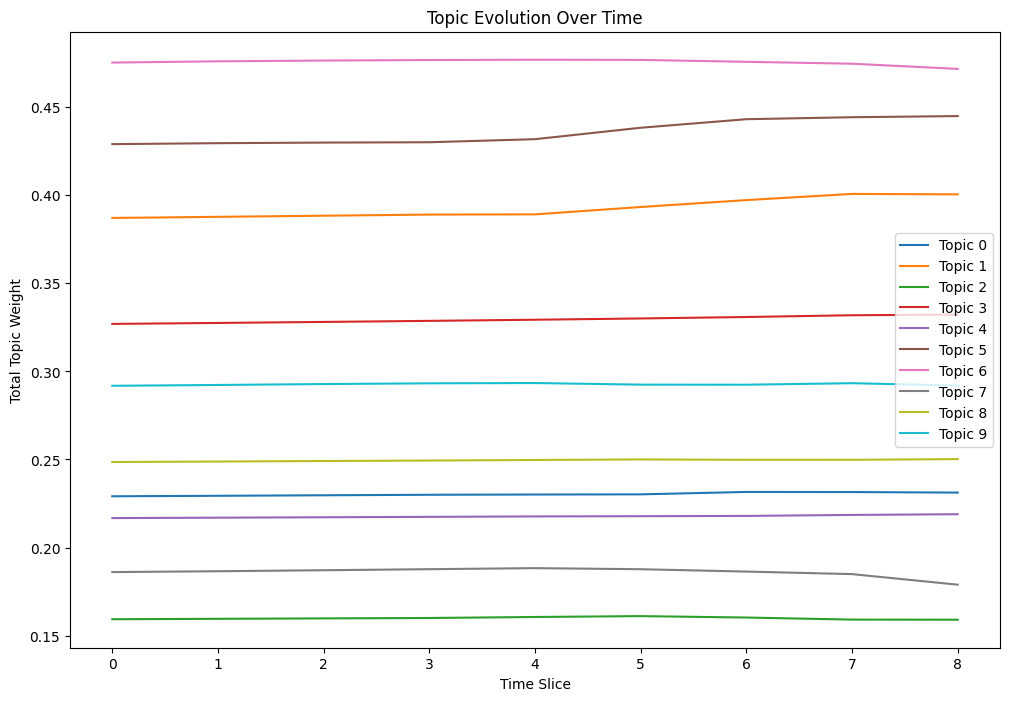

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# 模型有10个主题
num_topics = 10
time_slices = len(time_slice)  # 时间片数量

# 创建空的数组来存储每个主题在每个时间片的总权重
topic_evolution_over_time = np.zeros((num_topics, time_slices))

for topic_id in range(num_topics):
    for time in range(time_slices):
        # 获取特定主题在特定时间的分布
        topic_distribution = ldaseq.print_topic_times(topic=topic_id)[time]
        # 计算该时间片中所有词的总权重
        total_weight = sum(weight for word, weight in topic_distribution)
        topic_evolution_over_time[topic_id, time] = total_weight

# 绘图
plt.figure(figsize=(12, 8))
for topic_id in range(num_topics):
    plt.plot(range(time_slices), topic_evolution_over_time[topic_id], label=f'Topic {topic_id}')
plt.legend()
plt.title('Topic Evolution Over Time')
plt.xlabel('Time Slice')
plt.ylabel('Total Topic Weight')
plt.show()


In [63]:
from gensim.models import LdaSeqModel
from gensim.corpora import Dictionary, MmCorpus

# 加载模型
ldaseq = LdaSeqModel.load('/kaggle/working/ldaseq_model.gensim')

In [71]:
import numpy as np
# 存储结果的列表
topic_times = []

# 从time=0到time=8迭代
for t in range(9):
    topics_at_t = ldaseq.print_topics(time=t)
    topic_times.append(topics_at_t)

# 将列表转换为三维ndarray
Arr= np.array(topic_times)
# Arr.shape
Arr[8]#,Arr[0,0],Arr[0,0,0],Arr[0,0,0,0],

array([[['数据', '0.030576912996854635'],
        ['学习', '0.02084984753770577'],
        ['技术', '0.016950009105492166'],
        ['用户', '0.013264591917931452'],
        ['系统', '0.0130070115928069'],
        ['内容', '0.012087974655711195'],
        ['中', '0.011251551514130358'],
        ['领域', '0.011047780711667565'],
        ['语言', '0.010045107730630826'],
        ['理解', '0.009295992863317322'],
        ['云', '0.00911620564443204'],
        ['业务', '0.00875420903884375'],
        ['年', '0.008613095552768093'],
        ['产品', '0.008534463198128958'],
        ['信息', '0.008230303386293363'],
        ['分析', '0.008148915343063855'],
        ['2024', '0.008073140674830235'],
        ['训练', '0.007959109498966107'],
        ['自然语言', '0.007810433487083266'],
        ['小米', '0.0075656086206952414']],

       [['公司', '0.08636151021752406'],
        ['投资者', '0.046270827085695944'],
        ['董秘', '0.023247024659562198'],
        ['技术', '0.02212466893529167'],
        ['关注', '0.022121029912603556'],
  

In [68]:
# 将第二和第三个维度展平
Arr_reshaped = Arr.reshape(9, 200, 2)
print(Arr_reshaped.shape)

(9, 200, 2)


In [74]:
Arr_sort = np.zeros_like(Arr_reshaped)
for i in range(9):
    indices = np.argsort(Arr_reshaped[i, :, 1])[::-1]  
    Arr_sort[i] = Arr_reshaped[i, indices]


print("Sorted names and scores for the first exam:")
print(Arr_sort[0, :10]) 
print(Arr_sort.shape) 

Sorted names and scores for the first exam:
[['公司' '0.07600998686700774']
 ['生成' '0.0726660140791935']
 ['算力' '0.07130612189997568']
 ['产业' '0.05165438974581695']
 ['数据' '0.04920233368262547']
 ['社交' '0.04860257732089285']
 ['人工智能' '0.04761893822352114']
 ['投资者' '0.045240750587056074']
 ['AIGC' '0.044771754249592274']
 ['用户' '0.038927753979484385']]
(9, 200, 2)


In [75]:
Arr_top10 = np.zeros((9, 10, 2), dtype=object)
for i in range(9):
    Arr_top10[i] = Arr_sort[i, :10]  # 取前10名


for i in range(9):
    print(Arr_top10[i])
    print() 

[['公司' '0.07600998686700774']
 ['生成' '0.0726660140791935']
 ['算力' '0.07130612189997568']
 ['产业' '0.05165438974581695']
 ['数据' '0.04920233368262547']
 ['社交' '0.04860257732089285']
 ['人工智能' '0.04761893822352114']
 ['投资者' '0.045240750587056074']
 ['AIGC' '0.044771754249592274']
 ['用户' '0.038927753979484385']]

[['公司' '0.07628967925331281']
 ['生成' '0.07291912780263682']
 ['算力' '0.07159139283650867']
 ['产业' '0.051818507227037534']
 ['数据' '0.04933603681082562']
 ['社交' '0.04876889084538908']
 ['人工智能' '0.04776006515427062']
 ['投资者' '0.04535323592220807']
 ['AIGC' '0.0446960445544125']
 ['用户' '0.039018721653755944']]

[['公司' '0.07658937817682052']
 ['生成' '0.07323612393269034']
 ['算力' '0.07158958528708803']
 ['产业' '0.05201787844797003']
 ['数据' '0.04948177120966497']
 ['社交' '0.04899527840063024']
 ['人工智能' '0.0479301992299563']
 ['投资者' '0.04546465345192402']
 ['AIGC' '0.0444348228621614']
 ['用户' '0.03911816522472501']]

[['公司' '0.07688575494143621']
 ['生成' '0.07351427164312041']
 ['算力' '0.07156359

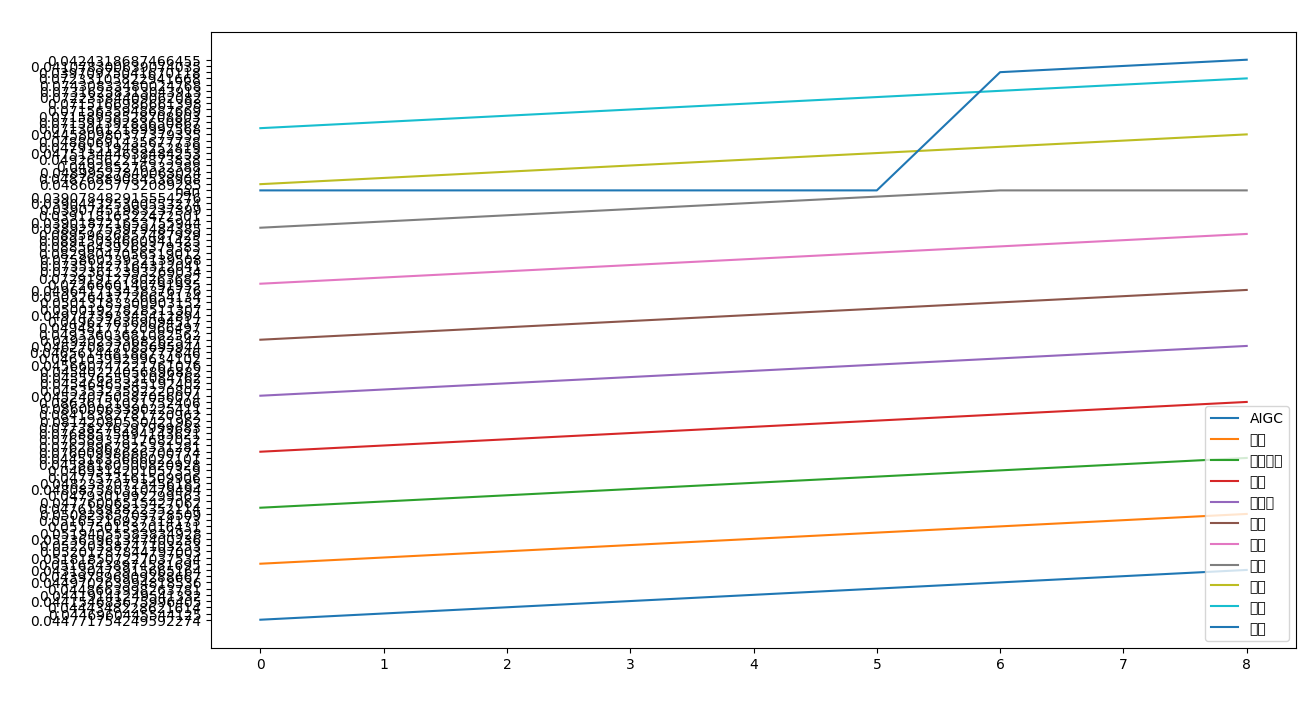

In [79]:
import matplotlib.pyplot as plt

names = np.unique(Arr_top10[:, :, 0])

scores_dict = {name: [np.nan] * 9 for name in names}

for exam_index in range(9):
    for student_index in range(10):
        name = Arr_top10[exam_index, student_index, 0]
        score = Arr_top10[exam_index, student_index, 1]
        scores_dict[name][exam_index] = score

plt.figure(figsize=(14, 8))
for name, scores in scores_dict.items():
    plt.plot(scores, label=name)

plt.title(' ')
plt.xlabel(' ')
plt.ylabel(' ')
plt.legend()
plt.show()